# Part 4: Finding Blasting Time

Air quality monitoring is regularly carried out at both dust generating and non-generating locations in the vicinity in order to evaluate the particulate pollution in and around the opencast mining projects of the Singrauli coalfield.

Air pollution measurements available via multi-sensory system are PM10, PM2.5, SO2, NO2, NOx, CO, NH3, O3 and BENZENE.



In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


During blasting, pollution levels reach their maximum.To detect these blasting times on each day, we will find out outliers in the givenb data and then find out corresponding timestamps. From those timestamps one with maximum frequency of outliers(i.e. blasting) will be the blasting time.

Here to find outliers, we have first replaced missing values with spline interpolation of order 3. After that a combined weighted combination "tot_col" is used to capture effective pattern in the concentration of pollutants across time.

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import pandas.plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

In [3]:
file_path = 'C:/Users/Omkar/Desktop/EE798Q/Open pit blasting 01-02-2023 000000 To 01-05-2023 235959.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path , index_col=0)

In [4]:
# Simplify column names
df.columns = ['from', 'to', 'PM10', 'PM2.5', 'NO','NO2','NOX','CO','SO2','NH3','Ozone','Benzene']
# deleting to column as we need only one timestamp column for to be index and we choose it to be from column
df = df.drop('to', axis=1)
# removing last 3 rows as they contaion max , min , avg data instead of actual observations
df = df.iloc[:-3]
df.tail()


,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
#,,,,,,,,,,,
8636,2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.63,10.0,10.7,26.1,0.1
8637,2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.57,10.0,10.4,30.9,0.1
8638,2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.58,9.9,10.5,29.6,0.1
8639,2023-05-01 23:30:00,19.0,11.0,20.8,100.2,70.2,0.58,9.5,10.8,30.0,0.1
8640,2023-05-01 23:45:00,32.0,6.0,21.8,98.8,70.3,NaN,NaN,11.0,33.5,0.1


In [5]:
# conveting timestamp as a string object into a datetime numerical 
date_format = '%Y-%m-%d %H:%M:%S'

# Convert the 'from' column to numerical datetime representation
df['from'] = pd.to_datetime(df['from'], format=date_format)


In [6]:
# set datetime "from" column as an index column
df.set_index('from', inplace=True)
df.head()

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2023-02-01 00:15:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
2023-02-01 00:30:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
2023-02-01 00:45:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
2023-02-01 01:00:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4


In [7]:
# # resample
# # df = df.resample('D').mean()
# interpolating
df = df.interpolate(method='spline',order=3)
df.fillna(method='ffill', inplace=True)  # Fill missing values forward
df.fillna(method='bfill', inplace=True)  # Fill missing values backward
# df = df.fillna(0)


In [8]:
# t=df.index[4500]
# msk=(df.index<=t)
# df = df[~msk].copy()


In [9]:
df

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,18.1,90.1,56.2,0.310000,8.200000,17.7,28.1,0.4
2023-02-01 00:15:00,95.0,35.0,18.1,88.0,55.1,0.330000,8.200000,18.3,27.1,0.4
2023-02-01 00:30:00,95.0,35.0,18.1,87.7,55.2,0.380000,8.200000,19.7,24.9,0.4
2023-02-01 00:45:00,122.0,34.0,18.1,88.9,55.7,0.380000,8.200000,21.3,21.9,0.4
2023-02-01 01:00:00,122.0,34.0,18.1,90.0,55.8,0.380000,8.200000,22.3,16.7,0.4
...,...,...,...,...,...,...,...,...,...,...
2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.630000,10.000000,10.7,26.1,0.1
2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.570000,10.000000,10.4,30.9,0.1
2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.580000,9.900000,10.5,29.6,0.1


The weights are decided by the same way as before in section "Finding combined weighted mean."

(i.e. wt= mean of column/sum of means of all columns)

In [10]:
weights=[0.398,0.166,0.032,0.123,0.094,3,0.075,0.029,0.078,0.0004]
# Define the weights for each column

In [11]:
# Calculate the weighted mean across the columns
df['tot_pol'] = (df.iloc[:, :10] * weights).sum(axis=1)

In [12]:
import pandas as pd

# Assuming your DataFrame is named 'df'

# Calculate mean and standard deviation
mean = df['tot_pol'].mean()
std = df['tot_pol'].std()

# Filter outliers based on the condition (greater than mean + 2 * standard deviation)
outliers = df[df['tot_pol'] > (mean + 1.5* std)]



# Count the frequency of outliers for each time
outliers_count = outliers.groupby(outliers.index.time).size()

# Find the time with the most frequent outlier occurrences
most_frequent_time = outliers_count.idxmax()

# Print the most frequent time and its frequency
print("Most Frequent Blasting Time:")
print(f"Time: {most_frequent_time}")



Most Frequent Blasting Time:
Time: 20:45:00


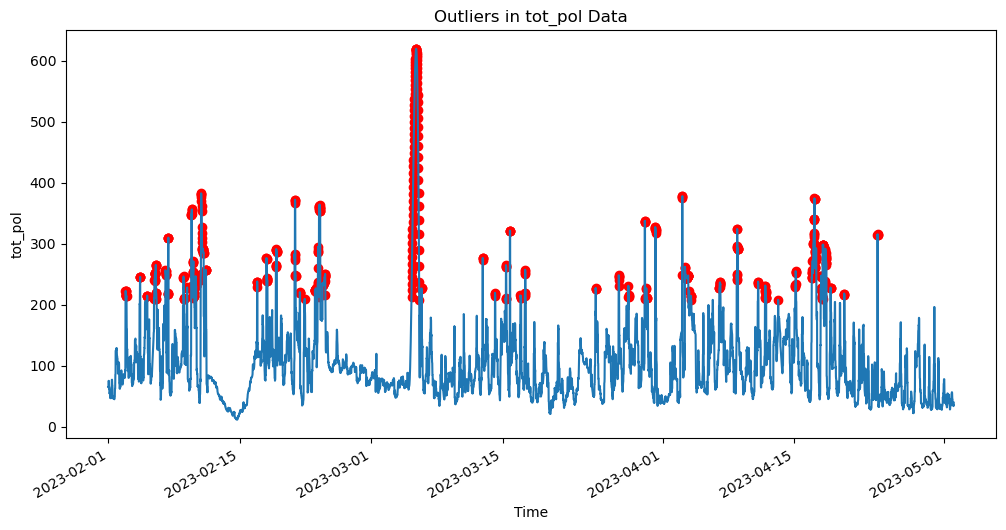

In [13]:
# Plot the outliers in a new graph
outliers.plot(y='tot_pol', style='ro', figsize=(12, 6), legend=False)
df['tot_pol'].plot()
plt.xlabel('Time')
plt.ylabel('tot_pol')
plt.title('Outliers in tot_pol Data')
plt.show()


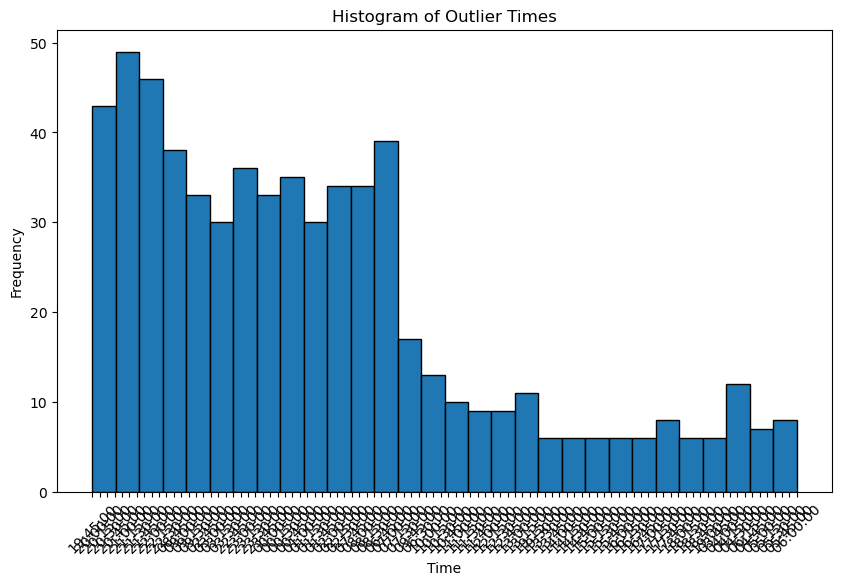

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
outlier_times = outliers.index.strftime('%H:%M:%S')  # Convert datetime to string format

plt.figure(figsize=(10, 6))
plt.hist(outlier_times, bins=30, edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of Outlier Times')
plt.xticks(rotation=45)
plt.show()


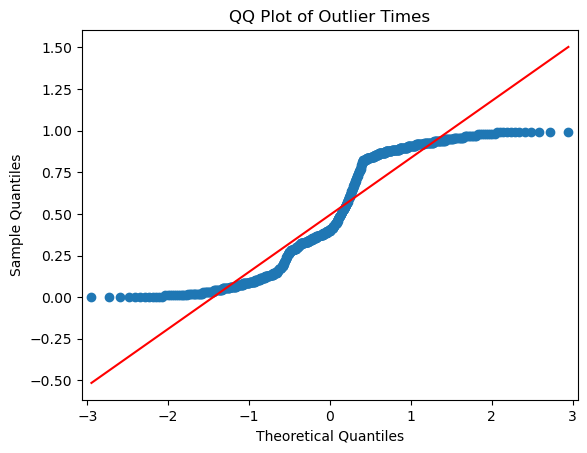

In [15]:
import statsmodels.api as sm
%matplotlib inline
# Perform a QQ plot to infer the distribution (Normal or not)
# Convert outlier times to fractional values of a day
outlier_times_numeric = pd.to_timedelta(outlier_times).total_seconds() / (60 * 60 * 24)

# Perform a QQ plot using the outlier times
sm.qqplot(outlier_times_numeric, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot of Outlier Times')
plt.show()

As the curve is not lying along the red line, this indicates that data is not following normal distribution.

In [16]:
# Find the probability of outliers happening during 14:15 to 14:30
start_time = pd.to_datetime('14:15:00').time()
end_time = pd.to_datetime('14:30:00').time()

outliers_between_interval = outliers[(outliers.index.time >= start_time) & (outliers.index.time <= end_time)]
probability = len(outliers_between_interval) / len(outliers)

print(f"Probability of blasting between {start_time} and {end_time}: {probability}")

Probability of blasting between 14:15:00 and 14:30:00: 0.006389776357827476




Hence the probability of open-pit blast happening during 14:15 to 14:30 is 0.5%.